# Extra - Tips and Tricks 1

In this example file we will dive a bit more into pyOMA2 functionalities.
Check out the documentation to get a full description of the various classes, functions, attributes, method and arguments (https://pyoma.readthedocs.io/en/main/).

To start the analysis we need to have the data loaded as an array with shape (Ndat, Nchannels), where Ndat is the number of datapoints (i.e. sampling frequency * period of acquisition), and Nchannels is the number of sensors/channels. 

In [1]:
import os
import sys
import numpy as np
# Add the directory we execute the script from to path:
sys.path.insert(0, os.path.realpath('__file__'))

# import the necessary functions and classes
from pyoma2.functions.gen import example_data
from pyoma2.setup.single import SingleSetup
from pyoma2.algorithms.data.run_params import EFDDRunParams, SSIRunParams
from pyoma2.algorithms.fdd import FSDD
from pyoma2.algorithms.ssi import SSIcov
from pyoma2.functions.plot import plot_mac_matrix, plot_mode_complexity
from pyoma2.functions.gen import save_to_file, load_from_file

# generate example data and results
data, ground_truth = example_data()

# Create an instance of the setup class
simp_5dof = SingleSetup(data, fs=600)

Once we have created the instance of the setup class we have access to a series of methods (and attributes) that let us inspect the data:
- The ```data``` attribute stores the input data.
- The ```fs``` attribute stores the sampling frequency.
- The ```dt``` attribute stores the sampling interval.
- The ```algorithms``` attribute stores the algorithms associated with the setup.
- The ```plot_STFT()``` method is used to plot the Short-Time Fourier Transform (STFT) magnitude spectrogram for the specified channels, useful to get a graphical feedback regarding the time invariance of the data.
- The ```plot_ch_info()``` method plots information for the specified channels, including time history, normalized auto-correlation, power spectral density (PSD), probability density function, and normal probability plot, useful to get a feedback regarding the quality of the data.
- The ```plot_data()``` method plots the time histories of the data channels in a subplot format.

Moreover we have access to some methods useful to pre-process the data at hand:
- The ```decimate_data()``` method decimates the data.
- The ```detrend_data()``` method detrends the data.
- The ```filter_data()``` method applies a Butterworth filter to the data.
- The ```rollback()``` method restores the data and sampling frequency to their initial state.


In [2]:
# Decimate the data
simp_5dof.decimate_data(q=30)

Once we´re done with the pre-processing we can start with the analysis. 

The next step is the initialisation of the desired OMA algorithms that will be added to the setup instance. 

The parameters required to run each algorithm can be passed one by one to the algorithm instance or in group through the ```run_params``` argument. 

In [3]:
# Import FSDD run parameters (default values) and print out as dictionary
fsdd_runpar = EFDDRunParams()
dict(fsdd_runpar)

{'nxseg': 1024, 'method_SD': 'per', 'pov': 0.5}

In [4]:
# Do the same for SSI, changing some of the default arguments
ssi_runpar = SSIRunParams(br=50, ordmax=50, calc_unc=True)
dict(ssi_runpar)

{'br': 50,
 'method': None,
 'ref_ind': None,
 'ordmin': 0,
 'ordmax': 50,
 'step': 1,
 'sc': {'err_fn': 0.05, 'err_xi': 0.05, 'err_phi': 0.05},
 'hc': {'xi_max': 0.1, 'mpc_lim': 0.5, 'mpd_lim': 0.5, 'CoV_max': 0.05},
 'calc_unc': True,
 'nb': 50}

In [5]:
# Initialise the algorithms
fsdd = FSDD(name="FSDD", run_params=fsdd_runpar)
# Equivalent to
fsdd1 = FSDD(name="FSDD1")

ssicov = SSIcov(name="SSIcov", run_params=ssi_runpar)
# Equivalent to
ssicov1 = SSIcov(name="SSIcov1", br=50, ordmax=50, calc_unc=True)

The ```run_params``` attribute of the algorithm instance let us inspect the parameters passed and overwrite/update them if needed.

In [6]:
# Inspect the parameters passed
print("SSI run parameters: ", ssicov.run_params)

# Overwrite/update run parameters for an algorithm
fsdd.run_params = FSDD.RunParamCls(nxseg=2048, method_SD="cor", pov=0.5)
print("")
print("FSDD run parameters: ", fsdd.run_params)

SSI run parameters:  br=50 method=None ref_ind=None ordmin=0 ordmax=50 step=1 sc={'err_fn': 0.05, 'err_xi': 0.05, 'err_phi': 0.05} hc={'xi_max': 0.1, 'mpc_lim': 0.5, 'mpd_lim': 0.5, 'CoV_max': 0.05} calc_unc=True nb=50

FSDD run parameters:  nxseg=2048 method_SD='cor' pov=0.5


With the new release we have moved some of the parameters that were actually used for the ```mpe()``` and ```mpe_from_plot()``` methods to a specialised class ```MPEParams```.

Now the algorithms can be added to the setup instance and executed collectively or by name.

In [7]:
# Add algorithms to the class
simp_5dof.add_algorithms(fsdd, ssicov)

# to check which algorithms have been added, we can call the algorithms attribute
simp_5dof.algorithms

{'FSDD': <pyoma2.algorithms.fdd.FSDD at 0x15fffdf10>,
 'SSIcov': <pyoma2.algorithms.ssi.SSIcov at 0x15fffdd00>}

In [8]:
# run all
simp_5dof.run_all()
# or run by name
# simp_5dof.run_by_name("SSIcov", "FSDD")

2025-02-10 09:14:35,497 - pyoma2.setup.base - INFO - Running FSDD... (base:123)
2025-02-10 09:14:35,516 - pyoma2.setup.base - INFO - Running SSIcov... (base:123)
2025-02-10 09:14:35,516 - pyoma2.functions.ssi - INFO - Assembling Hankel matrix method: cov... (ssi:82)
2025-02-10 09:14:35,545 - pyoma2.functions.ssi - INFO - ... calculating cov(H)... (ssi:93)
2025-02-10 09:14:35,612 - pyoma2.functions.ssi - INFO - SSI for increasing model order... (ssi:321)
100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 30960.99it/s]
2025-02-10 09:14:35,650 - pyoma2.functions.ssi - INFO - ... propagating uncertainty... (ssi:448)
100%|███████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.20it/s]
2025-02-10 09:14:38,398 - pyoma2.functions.ssi - INFO - Calculating modal parameters for increasing model order... (ssi:486)
100%|███████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 46.59it/s]
2025-02-10 09:14:39,573 - pyo

Once the algorithms have been run, we gain access to plotting options such as:
- The ```plot_CMIF()``` method for the FDD family of classes, which shows the plot of the singular values of the Spectral Density matrix.
- The ```plot_stab()``` method for the SSI family of classes, which shows the stabilisation of the identified poles for increasing model order.

SSI algorithms have also access to the ```plot_freqvsdamp()``` method which shows the frequency-damping cluster diagram.

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Frequency-damping clustering'}, xlabel='Frequency [Hz]', ylabel='Damping'>)

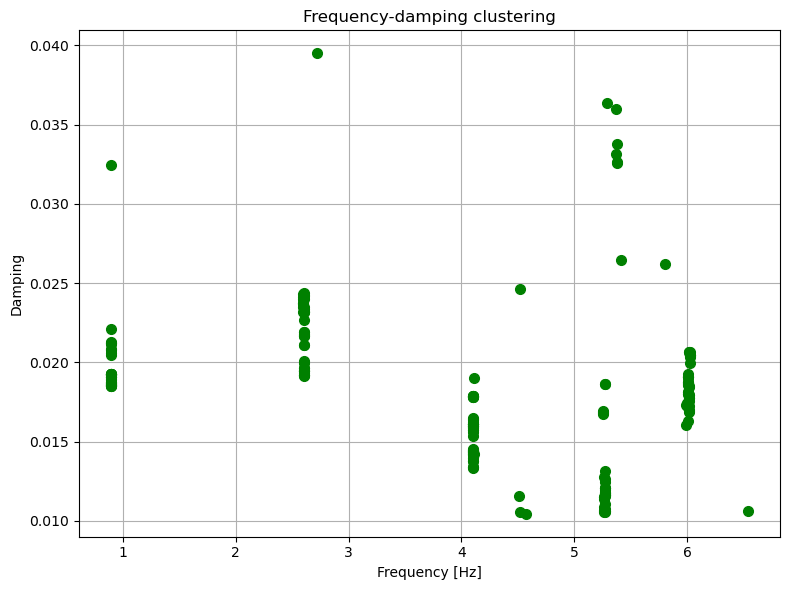

In [9]:
ssicov.plot_freqvsdamp()

The modal results can then be selected "manually" with the ```mpe()``` method or through an interactive version of the ```plot_CMIF()``` and  ```plot_stab()```, using the ```mpe_from_plot()``` method. As mentioned previously the arguments passed to these two methods will be stored in a specialised class accessible through the ```mpe_params``` attribute (after the method has been called)

In order to select a mode press the ```SHIFT``` button and left click on the desired peak/pole, to remove the last selected pole press ```SHIFT``` and right click, finally pressing ```SHIFT``` and the middle button will remove the closest selected peack/pole.

In [10]:
# get the modal parameters with the interactive plot
simp_5dof.mpe_from_plot("FSDD", freqlim=(0, 8))
simp_5dof.mpe_from_plot("SSIcov", freqlim=(0, 8))

2025-02-10 09:14:39,647 - pyoma2.setup.base - INFO - Getting mpe modal parameters from plot... FSDD (base:171)
2025-02-10 09:14:41.056 python[37201:78235132] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-10 09:14:41.056 python[37201:78235132] +[IMKInputSession subclass]: chose IMKInputSession_Modern
2025-02-10 09:14:52,605 - pyoma2.functions.fdd - INFO - Extracting FDD modal parameters (fdd:284)
100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11795.01it/s]
2025-02-10 09:14:52,607 - pyoma2.functions.fdd - INFO - Extracting EFDD modal parameters (fdd:492)
100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.77it/s]
2025-02-10 09:14:52,686 - pyoma2.setup.base - INFO - Getting mpe modal parameters from plot... SSIcov (base:171)
2025-02-10 09:15:03,345 - pyoma2.functions.ssi - INFO - Extracting SSI modal parameters (ssi:889)
100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 7715.

<Figure size 640x480 with 0 Axes>

Once the algorithms have been run and the modes extracted, we can access the results. We can inspect the whole dictionary of results at once, or access the single results one by one. 

In [11]:
# check the mpe_params
fsdd.mpe_params

EFDDMPEParams(sel_freq=None, DF1=0.1, DF2=1.0, cm=1, MAClim=0.85, sppk=3, npmax=20)

In [12]:
# dict of results
fsdd_res = dict(fsdd.result)
fsdd.result.Fn
# fsdd_res["Fn"]

array([0.90626215, 2.58054322, 4.05809385, 5.27508406, 6.00974657])

In [13]:
ssicov_res = dict(ssicov.result)
ssicov.result.Fn_std
# ssicov_res["Fn_std"]

array([0.00453131, 0.0149126 , 0.0104279 , 0.03163518, 0.03155055])

For the EFDD and FSDD algorithms the ```plot_EFDDfit()``` method generates a plot helping to visualise the quality and accuracy of modal identification.

There are also some useful functions in the ```plot``` module and in the ```gen``` module that can be used for further inspection of the results and saving/loading purposes:
- The ```plot_mac_matrix()``` function can be used to plot the MAC matrix, useful to compare different set of results.
- The ```plot_mode_complexity()``` function can be used to plot how "complex" a mode is.
- The ```load_from_file()``` function can be used to load a setup instance from a file.
- The ```save_to_file()``` function can be used to save a setup instance to a file.

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'MAC Matrix'}, xlabel='Array 1', ylabel='Array 2'>)

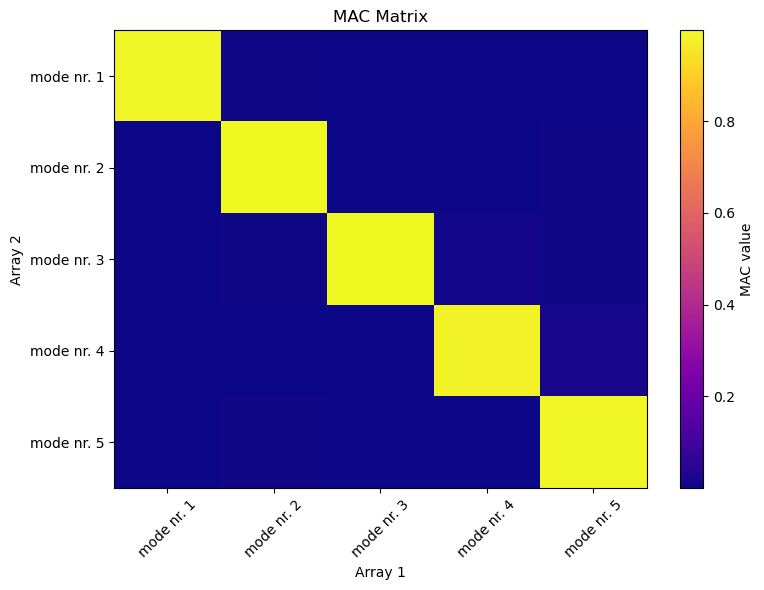

In [14]:
# plot the mac matrix between the SSI and FSDD results
plot_mac_matrix(ssicov_res['Phi'].real, fsdd_res['Phi'].real)
# equivalent to
# plot_mac_matrix(ssi.result.Phi.real, fsdd.result.Phi.real)

(<Figure size 600x600 with 1 Axes>,
 <PolarAxes: title={'center': 'Mode Shape Complexity Plot'}>)

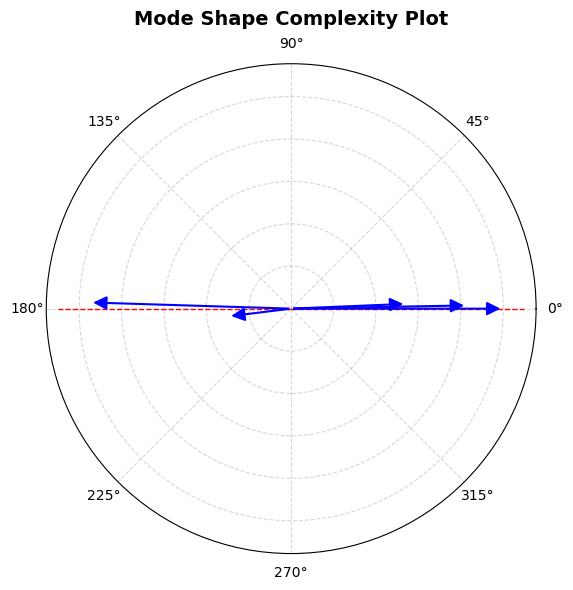

In [15]:
plot_mode_complexity(ssicov_res['Phi'][2])